In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 10

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 5s 48ms/step - loss: 0.5287 - accuracy: 0.7510 - val_loss: 0.5584 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.7611
Epoch 00002: val_loss improved from inf to 0.46229, saving model to best_model_11.h5
99/99 [==============================] - 4s 42ms/step - loss: 0.4708 - accuracy: 0.7611 - val_loss: 0.4623 - val_accuracy: 0.7966
Epoch 3/200
98/99 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.7873
Epoch 00003: val_loss did not improve from 0.46229
99/99 [==============================] - 4s 44ms/step - loss: 0.4515 - accuracy: 0.7880 - val_loss: 0.4772 - val_accuracy: 0.7728
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.7734
Epoch 00004: val_loss improved from 0.46229 to 0.41687, saving model to best_model_11.h5
99/99 [==============================] - 5s 49ms/step - loss: 0.4444 - accuracy: 0.7734 

Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8717
Epoch 00030: val_loss did not improve from 0.30715
99/99 [==============================] - 4s 43ms/step - loss: 0.2974 - accuracy: 0.8717 - val_loss: 0.4450 - val_accuracy: 0.7272
Epoch 31/200
98/99 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8658
Epoch 00031: val_loss did not improve from 0.30715
99/99 [==============================] - 4s 43ms/step - loss: 0.2913 - accuracy: 0.8666 - val_loss: 0.3642 - val_accuracy: 0.8032
Epoch 32/200
98/99 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8814
Epoch 00032: val_loss improved from 0.30715 to 0.29463, saving model to best_model_11.h5
99/99 [==============================] - 4s 45ms/step - loss: 0.2800 - accuracy: 0.8815 - val_loss: 0.2946 - val_accuracy: 0.8831
Epoch 33/200
99/99 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8704
Epoch 00033: val_loss did not impro

Epoch 60/200
98/99 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8804
Epoch 00060: val_loss did not improve from 0.29463
99/99 [==============================] - 5s 45ms/step - loss: 0.2878 - accuracy: 0.8793 - val_loss: 0.3965 - val_accuracy: 0.8108
Epoch 61/200
99/99 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.8847
Epoch 00061: val_loss did not improve from 0.29463
99/99 [==============================] - 4s 45ms/step - loss: 0.2785 - accuracy: 0.8847 - val_loss: 0.3129 - val_accuracy: 0.8593
Epoch 62/200
99/99 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8701
Epoch 00062: val_loss did not improve from 0.29463
99/99 [==============================] - 4s 44ms/step - loss: 0.3145 - accuracy: 0.8701 - val_loss: 0.5056 - val_accuracy: 0.8432
Epoch 63/200
99/99 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8580
Epoch 00063: val_loss did not improve from 0.29463
99/99 [===============

Epoch 89/200
98/99 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8909
Epoch 00089: val_loss did not improve from 0.25293
99/99 [==============================] - 4s 45ms/step - loss: 0.2681 - accuracy: 0.8910 - val_loss: 0.3122 - val_accuracy: 0.8745
Epoch 90/200
98/99 [============================>.] - ETA: 0s - loss: 0.2657 - accuracy: 0.8897
Epoch 00090: val_loss did not improve from 0.25293
99/99 [==============================] - 4s 43ms/step - loss: 0.2674 - accuracy: 0.8894 - val_loss: 0.3009 - val_accuracy: 0.8850
Epoch 91/200
98/99 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8929
Epoch 00091: val_loss did not improve from 0.25293
99/99 [==============================] - 4s 45ms/step - loss: 0.2644 - accuracy: 0.8932 - val_loss: 0.2737 - val_accuracy: 0.8859
Epoch 92/200
99/99 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8989
Epoch 00092: val_loss did not improve from 0.25293
99/99 [===============

98/99 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8807
Epoch 00118: val_loss did not improve from 0.24976
99/99 [==============================] - 5s 47ms/step - loss: 0.2878 - accuracy: 0.8802 - val_loss: 0.3275 - val_accuracy: 0.8555
Epoch 119/200
98/99 [============================>.] - ETA: 0s - loss: 0.3250 - accuracy: 0.8578
Epoch 00119: val_loss did not improve from 0.24976
99/99 [==============================] - 4s 45ms/step - loss: 0.3252 - accuracy: 0.8571 - val_loss: 0.3172 - val_accuracy: 0.8565
Epoch 120/200
98/99 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8782
Epoch 00120: val_loss did not improve from 0.24976
99/99 [==============================] - 5s 46ms/step - loss: 0.2920 - accuracy: 0.8790 - val_loss: 0.2669 - val_accuracy: 0.8888
Epoch 121/200
98/99 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.8941
Epoch 00121: val_loss improved from 0.24976 to 0.22938, saving model to best_model_

Epoch 148/200
99/99 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8973
Epoch 00148: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 38ms/step - loss: 0.2648 - accuracy: 0.8973 - val_loss: 0.2736 - val_accuracy: 0.9059
Epoch 149/200
99/99 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8862
Epoch 00149: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 38ms/step - loss: 0.2856 - accuracy: 0.8862 - val_loss: 0.2566 - val_accuracy: 0.8926
Epoch 150/200
99/99 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8777
Epoch 00150: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 38ms/step - loss: 0.3014 - accuracy: 0.8777 - val_loss: 0.2847 - val_accuracy: 0.8878
Epoch 151/200
99/99 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8549
Epoch 00151: val_loss did not improve from 0.22938
99/99 [===========

Epoch 178/200
99/99 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.7563
Epoch 00178: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 39ms/step - loss: 0.4601 - accuracy: 0.7563 - val_loss: 0.4670 - val_accuracy: 0.7947
Epoch 179/200
99/99 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.7855
Epoch 00179: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 40ms/step - loss: 0.4399 - accuracy: 0.7855 - val_loss: 0.4297 - val_accuracy: 0.8080
Epoch 180/200
98/99 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8342
Epoch 00180: val_loss did not improve from 0.22938
99/99 [==============================] - 4s 38ms/step - loss: 0.3762 - accuracy: 0.8337 - val_loss: 0.3504 - val_accuracy: 0.8489
Epoch 181/200
98/99 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8268
Epoch 00181: val_loss did not improve from 0.22938
99/99 [===========

33/33 - 0s - loss: 0.2294 - accuracy: 0.9040
27/27 - 0s - loss: 0.1816 - accuracy: 0.9313


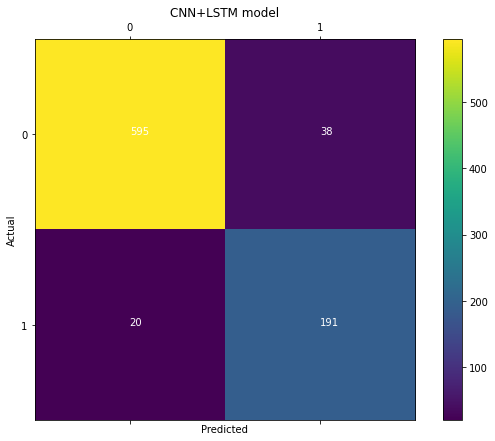

val_loss: 0.22937920689582825
test_loss: 0.18157215416431427
test_acc: 0.9312795996665955
precision: 0.834061135371179
recall: 0.9052132701421801
specificity 0.9399684044233807
sensitivity :  0.9052132701421801
far 0.06003159557661927
frr 0.0947867298578199


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 76, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 20, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 9, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.569149552203474)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(232)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(32, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(21, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(134, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.009755746313544013), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.08119450015184537, momentum=0.4770521140454941), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)